# Classifying the news

This project analyzes around 13,000 news articles published in March 2017 by 15 different publishers. The project aims to find out whether it is possible to classify, group or identify articles based on certain characteristics.

## Contents
- Data: This section details the data used as well as the data cleaning and feature engineering steps.
- Clustering: This section attempts to find similarities between different articles using clustering algorithms.

## Data

In [13]:
## Packages

## Standard packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from collections import Counter

## Word related packages
import spacy
import re
import gensim
from gensim.models import word2vec, doc2vec
from gensim.test.utils import get_tmpfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import nltk
from textblob import TextBlob

## Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
import itertools

# Neural Nets
from sklearn.neural_network import MLPClassifier

The data for this project came from [Kaggle](https://www.kaggle.com/snapcrack/all-the-news). The original dataset contained about 143,000 articles covering around 5 years. The amount of data was reduced to include March 2017 only in order to decrease model run time. March 2017 was chosen as it was one of the more recent months in the dataset and had a spread of articles across the month.

In [14]:
## Import data

march17news = pd.read_csv('march17news.csv', index_col=0)
march17news.head()

,title,publication,author,date,year,month,url,content,datetime
0,A ‘World Unto Itself’ in New York Area Yeshiva...,New York Times,Corey Kilgannon,2017-03-13,2017,3,NaN,In the basement of a mammoth old building in U...,2017-03-13
1,"Review: ‘The Present’: Even in Russia, It’s Ha...",New York Times,Ben Brantley,2017-03-27,2017,3,NaN,"As is so often the case, the party doesn’t rea...",2017-03-27
2,Danielle Brooks: The First Time I Saw Myself o...,New York Times,Danielle Brooks,2017-03-22,2017,3,NaN,"It was June 2012, and I had just sped out of t...",2017-03-22
3,Samsung Group Leader Is Named a Suspect in Sou...,New York Times,Choe Sang-Hun,2017-03-11,2017,3,NaN,"SEOUL, South Korea — A special prosecutor i...",2017-03-11
4,Australian Drug Maker Has Low Profile but Powe...,New York Times,Katie Thomas,2017-03-22,2017,3,NaN,SAN FRANCISCO — Innate Immunotherapeutics i...,2017-03-22


### Data cleaning
The data was checked to see what it contained and what was missing.

In [30]:
march17news.shape

(9581, 10)

In [15]:
## Find short / empty content

march17news['content_length'] = march17news['content'].apply(len)
march17news.head()

,title,publication,author,date,year,month,url,content,datetime,content_length
0,A ‘World Unto Itself’ in New York Area Yeshiva...,New York Times,Corey Kilgannon,2017-03-13,2017,3,NaN,In the basement of a mammoth old building in U...,2017-03-13,8098
1,"Review: ‘The Present’: Even in Russia, It’s Ha...",New York Times,Ben Brantley,2017-03-27,2017,3,NaN,"As is so often the case, the party doesn’t rea...",2017-03-27,6234
2,Danielle Brooks: The First Time I Saw Myself o...,New York Times,Danielle Brooks,2017-03-22,2017,3,NaN,"It was June 2012, and I had just sped out of t...",2017-03-22,5069
3,Samsung Group Leader Is Named a Suspect in Sou...,New York Times,Choe Sang-Hun,2017-03-11,2017,3,NaN,"SEOUL, South Korea — A special prosecutor i...",2017-03-11,4393
4,Australian Drug Maker Has Low Profile but Powe...,New York Times,Katie Thomas,2017-03-22,2017,3,NaN,SAN FRANCISCO — Innate Immunotherapeutics i...,2017-03-22,10463


In [19]:
march17news.loc[march17news['content_length'] < 50, ]

,title,publication,author,date,year,month,url,content,datetime,content_length
3234,This man dropped out of college twice and now ...,Business Insider,NaN,2017-03-17,2017,3,NaN,’’ ’ ’,2017-03-17,6
3768,Mass Effect: Andromeda Is More About Choice Th...,Atlantic,David Sims,2017-03-20,2017,3,NaN,,2017-03-20,2
4214,21 Of The Most Powerful Photos Of This Week,Buzzfeed News,Gabriel H. Sanchez,2017-03-12,2017,3,https://web.archive.org/web/20170312000259/htt...,,2017-03-12,4


In [32]:
## Find missing publications

march17news.loc[march17news['publication'].isna(), ]

,title,publication,author,date,year,month,url,content,datetime,content_length


In [33]:
## Find how many missing authors

len(march17news.loc[march17news['author'].isna(), ])

494

In [34]:
## Find which publications have missing authors

march17news.loc[march17news['author'].isna(), 'publication'].value_counts()

CNN                    231
Guardian               133
Business Insider        94
Talking Points Memo     20
NPR                     15
New York Times           1
Name: publication, dtype: int64

In [29]:
march17news.loc[:, 'publication'].value_counts()

New York Post          1584
Breitbart              1386
New York Times          994
Reuters                 804
NPR                     737
Guardian                735
Washington Post         660
CNN                     634
Atlantic                588
Buzzfeed News           409
Business Insider        400
Vox                     347
National Review         283
Talking Points Memo      20
Name: publication, dtype: int64

Removing missing authors would remove around one third of CNN articles and all of the Talking Points Memo articles. Articles with missing authors are retained at this stage.

In [35]:
## Remove rows where there is no content

march17news = march17news.loc[~(march17news['content_length'] < 50), ]
march17news.reset_index(drop=True, inplace=True)

In [36]:
## Split into train and test sets

train, test = train_test_split(march17news, random_state=76)
train.reset_index(inplace=True)
train.rename(columns={'index': 'article_id'}, inplace=True)

### Train models

Five different methods of analyzing text data were considered in this project - overall article vector using doc2vec, the article's average word2vec vector, the article's maximum word2vec vector, spacy tokens and tf-idf. Here the data is converted into these four formats.

#### doc2vec

In [37]:
def create_corpus(data):
    for i in np.arange(0, len(data)):
        yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(data.loc[i, 'content']), [i])

In [38]:
start_time = time.process_time()
train_articles = list(create_corpus(train))
print(time.process_time() - start_time)

9.252548999999988


In [39]:
model_d2v = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=20)
model_d2v.build_vocab(train_articles)
start_time = time.process_time()
model_d2v.train(train_articles, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)
print(time.process_time() - start_time)

241.87499400000007


In [40]:
## Repeat for test set
test.reset_index(inplace=True)
test.rename(columns={'index': 'article_id'}, inplace=True)
test_articles = list(create_corpus(test))

In [62]:
def d2v_vectors(model):
    docvecs = []
    for i in np.arange(0, len(model)):
        docvecs.append(model[i])
    df = pd.DataFrame(docvecs)
    return df

In [63]:
x_train_d2v = d2v_vectors(model_d2v.docvecs)

In [64]:
def get_vectors(model, new_data):
    docvecs = []
    for i in np.arange(0, len(new_data)):
        docvecs.append(model.infer_vector(new_data[i].words))
    df = pd.DataFrame(docvecs)
    return df

In [65]:
x_test_d2v = get_vectors(model_d2v, test_articles)

#### Google word vectors

In [41]:
# Load Google's pre-trained Word2Vec model.
model_g = gensim.models.KeyedVectors.load_word2vec_format ('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)
google_wv = model_g.wv

/usr/local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
## Function to get word vector for each word

def word_vectors(data):
    all_wv = {}
    for row in np.arange(0, len(data)):
        row_wv = []
        article = data.loc[row, 'content'].split(sep=' ')
        for word in article:
            if word in google_wv.vocab:
                row_wv.append(model_g.wv.get_vector(word))
        all_wv[row] = row_wv
    return all_wv

In [43]:
start_time = time.process_time()
train_articles_g = word_vectors(train)
print(time.process_time() - start_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


23.405464000000052


In [44]:
## Generate a single vector for each article
## Try two - the average vector and the max vector

def av_max_vectors(data):
    av_vectors_g = []
    max_vectors_g = []
    for i in np.arange(0, len(data)):
        article = data[i]
        article_df = pd.DataFrame(article)
        article_df = article_df.T
        article_df['average'] = article_df.mean(axis=1)
        article_df['max'] = article_df.max(axis=1)
        av_vectors_g.append(np.asarray(article_df['average']))
        max_vectors_g.append(np.asarray(article_df['max']))
    return av_vectors_g, max_vectors_g

In [45]:
start_time = time.process_time()

av_train_g1, max_train_g1 = av_max_vectors(train_articles_g)

time.process_time() - start_time

471.88105800000005

In [54]:
## Repeat for test set

start_time = time.process_time()
test_articles_g = word_vectors(test)
print(time.process_time() - start_time)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


10.463572000000113


In [55]:
start_time = time.process_time()

av_test_g1, max_test_g1 = av_max_vectors(test_articles_g)

time.process_time() - start_time

181.3043560000001

#### Bag of Words with spaCy

In [46]:
nlp = spacy.load('en')
def create_nlp(data):

    nlp_col = []
    for row in data.index:
        nlp_list = []
        nlp_text = nlp(data.loc[row, 'content'])
        for token in nlp_text:
            if not token.is_punct and not token.is_stop:
                nlp_list.append(token)
        nlp_col.append(nlp_list)

    return pd.DataFrame({'article_id': data['article_id'],
                         'publication': data['publication'],
                         'content_nlp': nlp_col})

In [47]:
start_time = time.process_time()

train_nlp = create_nlp(train)

print(time.process_time() - start_time)

1066.1856289999998


In [48]:
## Find 2000 most common words

def common_words(data):
    all_words = []
    common_words = []
    for row in np.arange(0, len(data)):
        if (row % 1000 == 0):
            print('Row {} processing'.format(row))
        for token in data.loc[row, 'content_nlp']:
            all_words.append(token.lemma_)
    word_results = [item for item in Counter(all_words).most_common(2000)]
    for word in word_results:
        common_words.append(word[0])

    return common_words

In [49]:
start_time = time.process_time()

nlp_words = common_words(train_nlp)

time.process_time() - start_time

Row 0 processing
Row 1000 processing
Row 2000 processing
Row 3000 processing
Row 4000 processing
Row 5000 processing
Row 6000 processing
Row 7000 processing


8.719429999999647

In [50]:
def create_bow(df, words):

    start_time = time.process_time()
    
    df_bow = pd.DataFrame(columns=words)
    df_bow['content_nlp'] = df['content_nlp']
    df_bow['article_id'] = df['article_id']
    df_bow['publication'] = df['publication']

    for row in df_bow.index:
        allwords = df_bow.loc[row, 'content_nlp']
        allwords_count = [item for item in Counter(allwords).most_common()]
        for word in allwords_count:
            if str(word[0]) in words:
                df_bow.loc[row, str(word[0])] = word[1]
        if row % 1000 == 0:
            print('Processing row {}'.format(row))
            print('Time taken: {}'.format(time.process_time() - start_time))
    
    return df_bow

In [51]:
train_bow = create_bow(train_nlp, nlp_words)

Processing row 0
Time taken: 1.1194060000002537
Processing row 1000
Time taken: 170.169034
Processing row 2000
Time taken: 346.8810819999999
Processing row 3000
Time taken: 505.29644700000017
Processing row 4000
Time taken: 656.0957429999999
Processing row 5000
Time taken: 815.0979470000002
Processing row 6000
Time taken: 965.614458
Processing row 7000
Time taken: 1117.6905230000002


In [52]:
train_bow.fillna(0, inplace=True)

In [53]:
x_train_bow = train_bow.drop(['content_nlp', 'article_id', 'publication'], axis=1)

In [56]:
## Repeat for test set

start_time = time.process_time()

test_nlp = create_nlp(test)

print(time.process_time() - start_time)

358.163857


In [57]:
test_bow = create_bow(test_nlp, nlp_words)

Processing row 0
Time taken: 1.0151459999997314
Processing row 1000
Time taken: 126.01802700000007
Processing row 2000
Time taken: 244.8551120000002


In [58]:
test_bow.fillna(0, inplace=True)
x_test_bow = test_bow.drop(['content_nlp', 'article_id', 'publication'], axis=1)

#### tf-idf

In [59]:
train_str = train.loc[:, 'content'].values

In [60]:
vectorizer = TfidfVectorizer(max_df = 0.9,
                            min_df = 10,
                            stop_words='english',
                            use_idf=True,
                             lowercase=False,
                            norm=u'l2',
                            smooth_idf=True)

In [105]:
start_time = time.process_time()

x_train_tfidf_v = vectorizer.fit(train_str)
x_train_tfidf = x_train_tfidf_v.transform(train_str)
print('Number of features: {}'.format(x_train_tfidf.get_shape()[1]))

time.process_time() - start_time

Number of features: 19400


11.225910999999542

In [106]:
test_str = test.loc[:, 'content'].values
x_test_tfidf = x_train_tfidf_v.transform(test_str)

## Clustering

### Clustering by publication

The publications were rearranged into ideological order. This ordering was completed with reference to [mediabiaschart.com](mediabiaschart.com).

In [67]:
ideological_order = ['Vox', 'Buzzfeed News', 'Atlantic', 'Talking Points Memo', 'Washington Post', 'CNN', 'Guardian', 'NPR', 'New York Times', 'Reuters', 'Business Insider', 'New York Post', 'National Review', 'Breitbart']

In [75]:
## Count number of each publication for percentage calculations

pub_counts_train = pd.DataFrame(train['publication'].value_counts())
pub_counts_test = pd.DataFrame(test['publication'].value_counts())

In [69]:
## Formula to convert results into percentages within each cluster

def table_pct(df, totals):
    df_new = pd.DataFrame(columns=ideological_order)
    for row in df.index:
        for pub in totals.index:
            df_new.loc[row, pub] = df.loc[row, pub] / totals.loc[pub, 'publication']
    return df_new

Using the KMeans algorithm, the training data was grouped into 25 clusters. This was done 5 times - once for each data format. The graphs below show the distribution of the publications within each cluster.

#### doc2vec publication clusters

In [76]:
## 25 clusters

kmeans_train_d2v25 = KMeans(n_clusters=25, random_state=76).fit(x_train_d2v)
ypred_train_d2v25 = kmeans_train_d2v25.predict(x_train_d2v)

train_d2v_cl25 = pd.crosstab(ypred_train_d2v25, train['publication'])
train_d2v_cl25pct = table_pct(train_d2v_cl25, pub_counts_train)
train_d2v_cl25pct.reset_index(inplace=True)
train_d2v_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_cl25pct_long = pd.melt(train_d2v_cl25pct, id_vars='cluster')

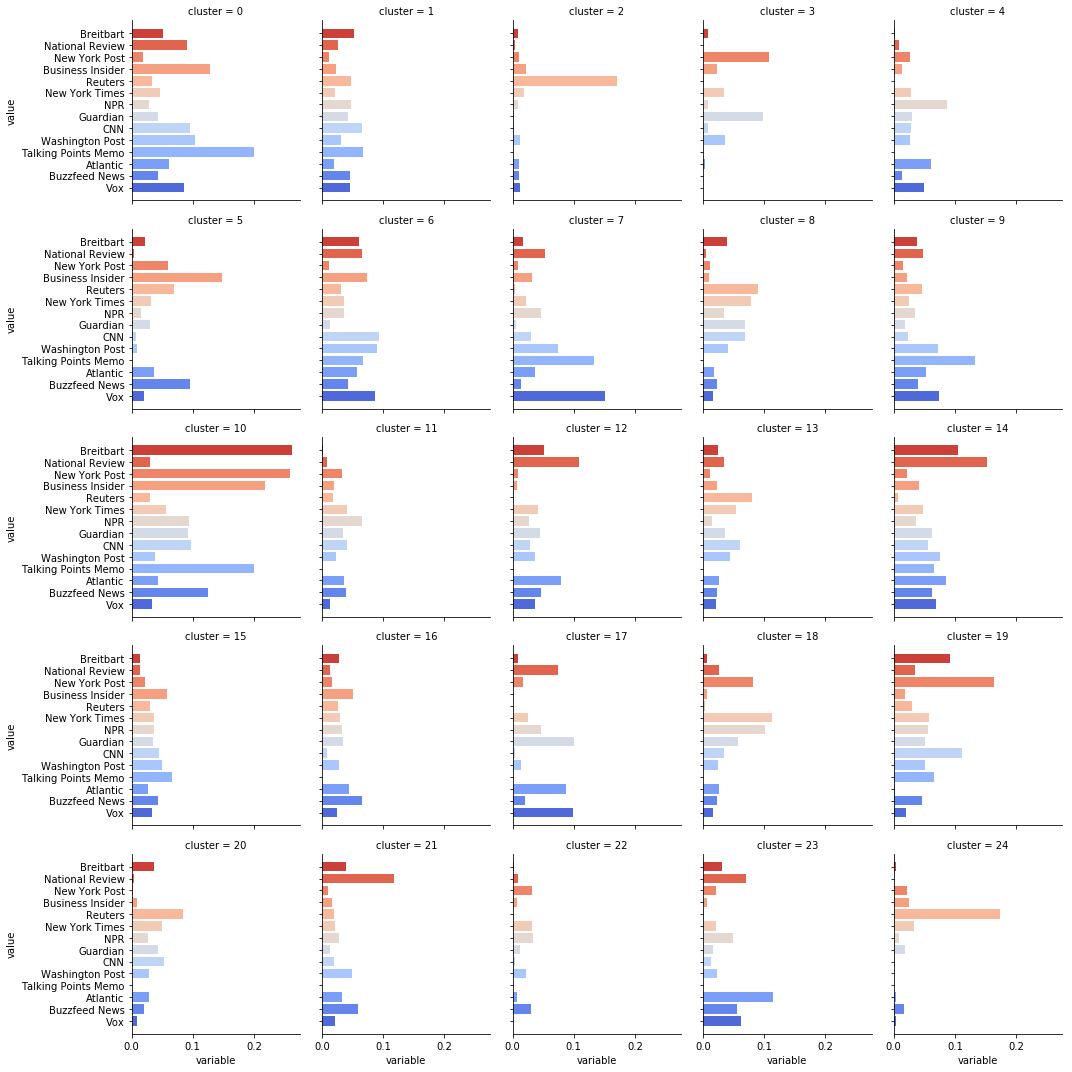

In [86]:
g = sns.FacetGrid(train_d2v_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The most noticeable feature of these clusters is that there are two clusters (2 and 24) which are essentially 'Reuters' clusters. No other publication stands out on its own in a cluster to such a large extent.

Most publications are distributed fairly evenly between several clusters, suggesting these clusters have not identified meaningful differences between the publications. However, the distribution of some clusters is more skewed, perhaps indicating an ideological bias. For example, cluster 7 appears to favor left-leaning publications, whereas cluster 19 is perhaps slightly skewed in the opposite direction. Some of the clusters (12, 14, 23) may indicate more biased publications in general, without discriminating between left or right wing. Cluster 8 by contrast groups several articles from publications more in the center ground.

To test whether these clusters are simply random groupings, the same clustering algorithm was used to predict the clusters of the test set. If the clusters do indicate the meanings set out above, the same publications should be found in the same clusters.

In [78]:
## Test doc2vec clusters

ypred_test_d2v25 = kmeans_train_d2v25.predict(x_test_d2v)

test_d2v_cl25 = pd.crosstab(ypred_test_d2v25, test['publication'])
test_d2v_cl25pct = table_pct(test_d2v_cl25, pub_counts_test)
test_d2v_cl25pct.reset_index(inplace=True)
test_d2v_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_d2v_cl25pct_long = pd.melt(test_d2v_cl25pct, id_vars='cluster')

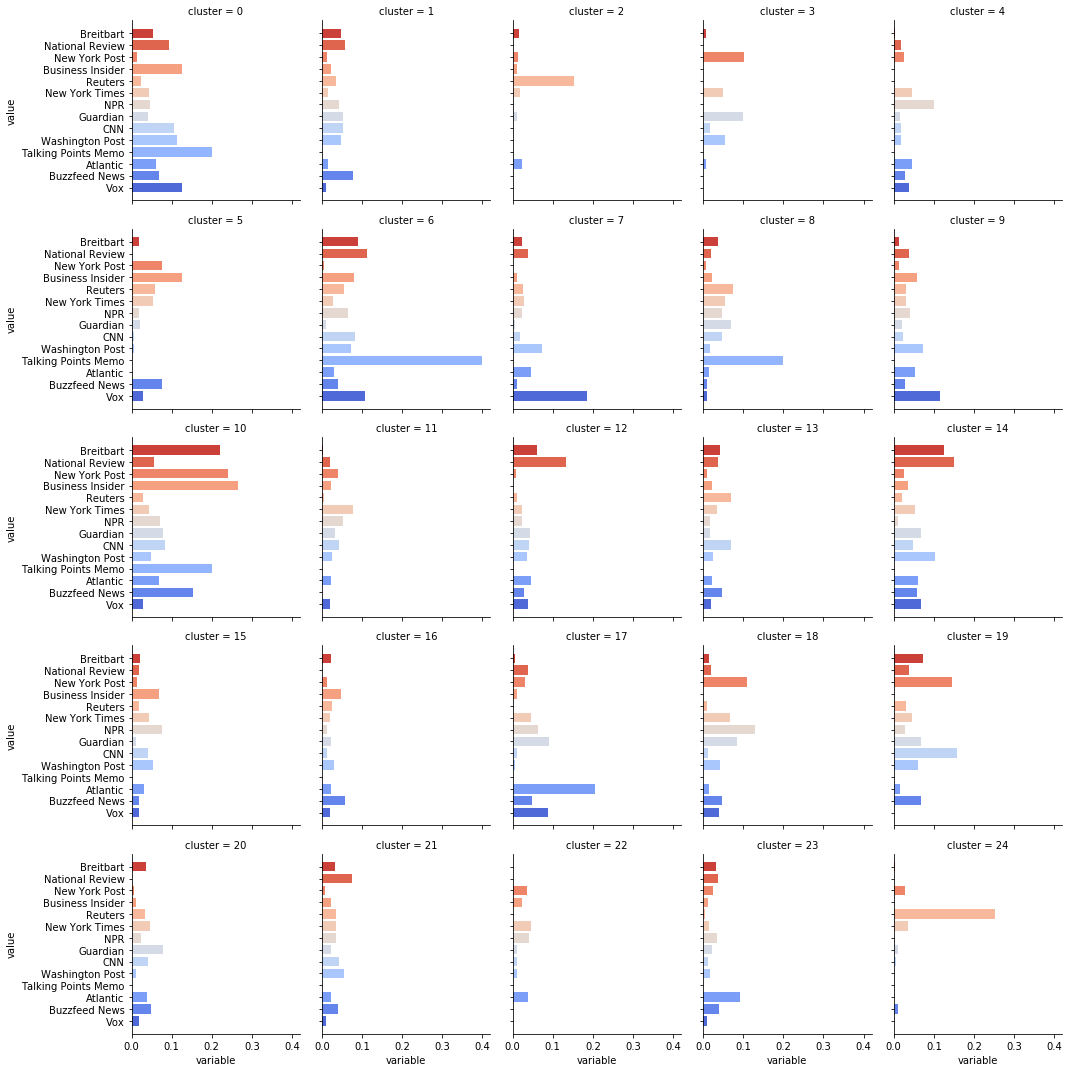

In [85]:
g = sns.FacetGrid(test_d2v_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The Reuters clusters appear to be stable as they have accurately grouped Reuters publications again. Cluster 7 has again identified mostly left wing publications, but cluster 19 has a more diverse spread so is unlikely to be an accurate predictor. Clusters 12, 14 and 23 again do appear to have slight predictive power in finding more ideologically extreme publications. Cluster 8 does contain mostly centrist publications again, but is overshadowed by a large proportion of Talking Points Memo articles, of which there were none in this cluster in the training set. This is likely to be because there are only 20 Talking Points Memo articles in the dataset, meaning there is not enough data to create a reliable model for this publication.

#### word2vec (average vector) publication clusters

In [81]:
## 25 clusters

kmeans_train_av_g1_25 = KMeans(n_clusters=25, random_state=76).fit(av_train_g1)
ypred_train_av_g1_25 = kmeans_train_av_g1_25.predict(av_train_g1)

train_av_g1_cl25 = pd.crosstab(ypred_train_av_g1_25, train['publication'])
train_av_g1_cl25pct = table_pct(train_av_g1_cl25, pub_counts_train)
train_av_g1_cl25pct.reset_index(inplace=True)
train_av_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_av_g1_cl25pct_long = pd.melt(train_av_g1_cl25pct, id_vars='cluster')

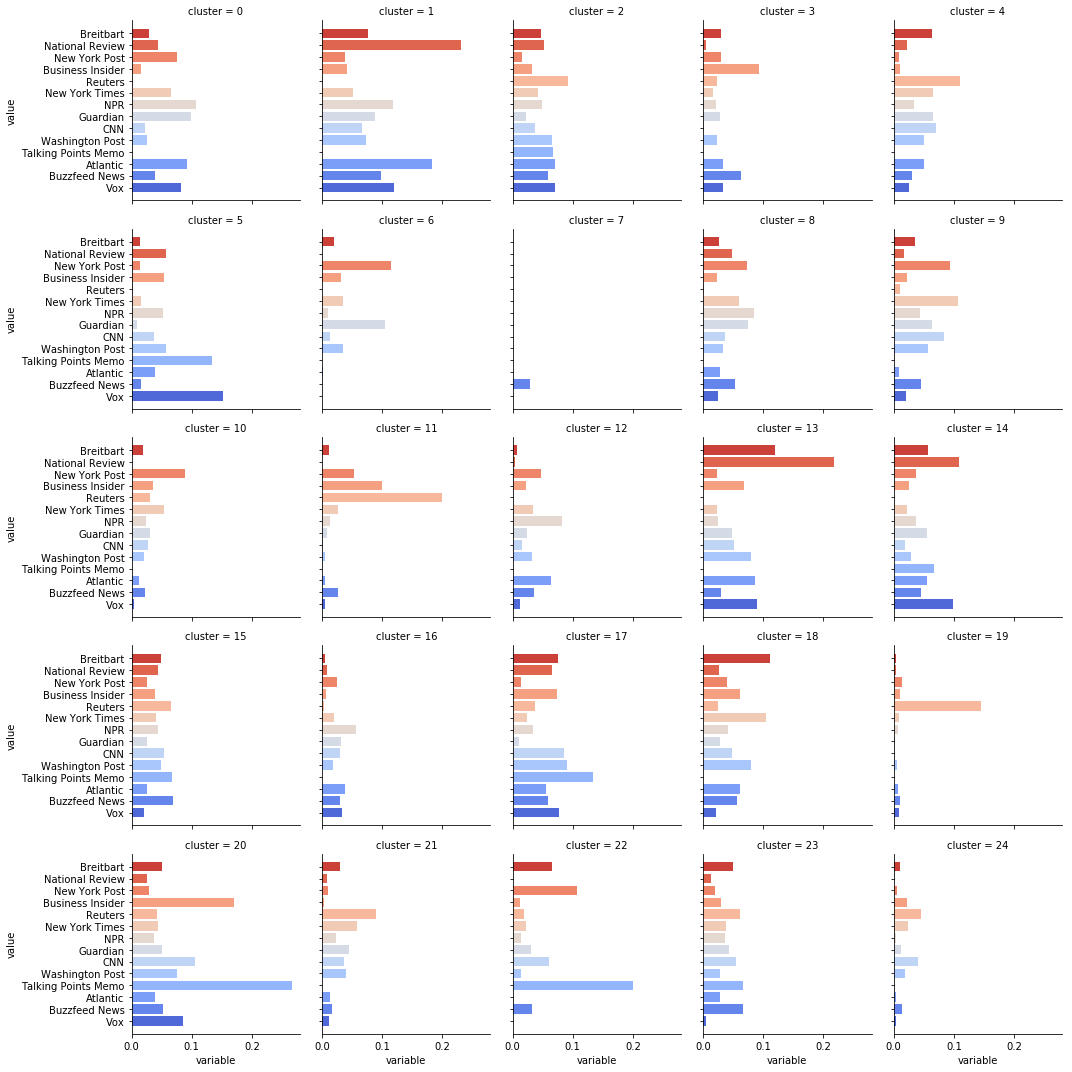

In [84]:
g = sns.FacetGrid(train_av_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Similarly to the doc2vec version, the average word2vec data clustering results in a Reuters cluster, this time cluster 19. However, this cluster only contains about 15% of Reuters articles whereas the two clear Reuters clusters previously contained around 40% of the articles between them. There are other clusters in this grouping which contain a significant proportion of Reuters articles, such as clusters 4 and 11, but not in the almost 'exclusive' way seen in cluster 19.

Only Buzzfeed News appears in cluster 7 but this is such a small proportion of total Buzzfeed articles it is basically irrelevant.

It is difficult to discern any clusters which appear to group left or right wing publications togather. Potentially cluster 5 identifies more left wing bias and cluster 13 identifies more right wing bias, but generally the clusters contain a reasonably even spread of publications. Clusters 4, 9 and 10 may been seen as identifying centrist publications.

These potential clusters were tested with the test set.

In [89]:
## 25 clusters

ypred_test_av_g1_25 = kmeans_train_av_g1_25.predict(av_test_g1)

test_av_g1_cl25 = pd.crosstab(ypred_test_av_g1_25, test['publication'])
test_av_g1_cl25pct = table_pct(test_av_g1_cl25, pub_counts_test)
test_av_g1_cl25pct.reset_index(inplace=True)
test_av_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_av_g1_cl25pct_long = pd.melt(test_av_g1_cl25pct, id_vars='cluster')

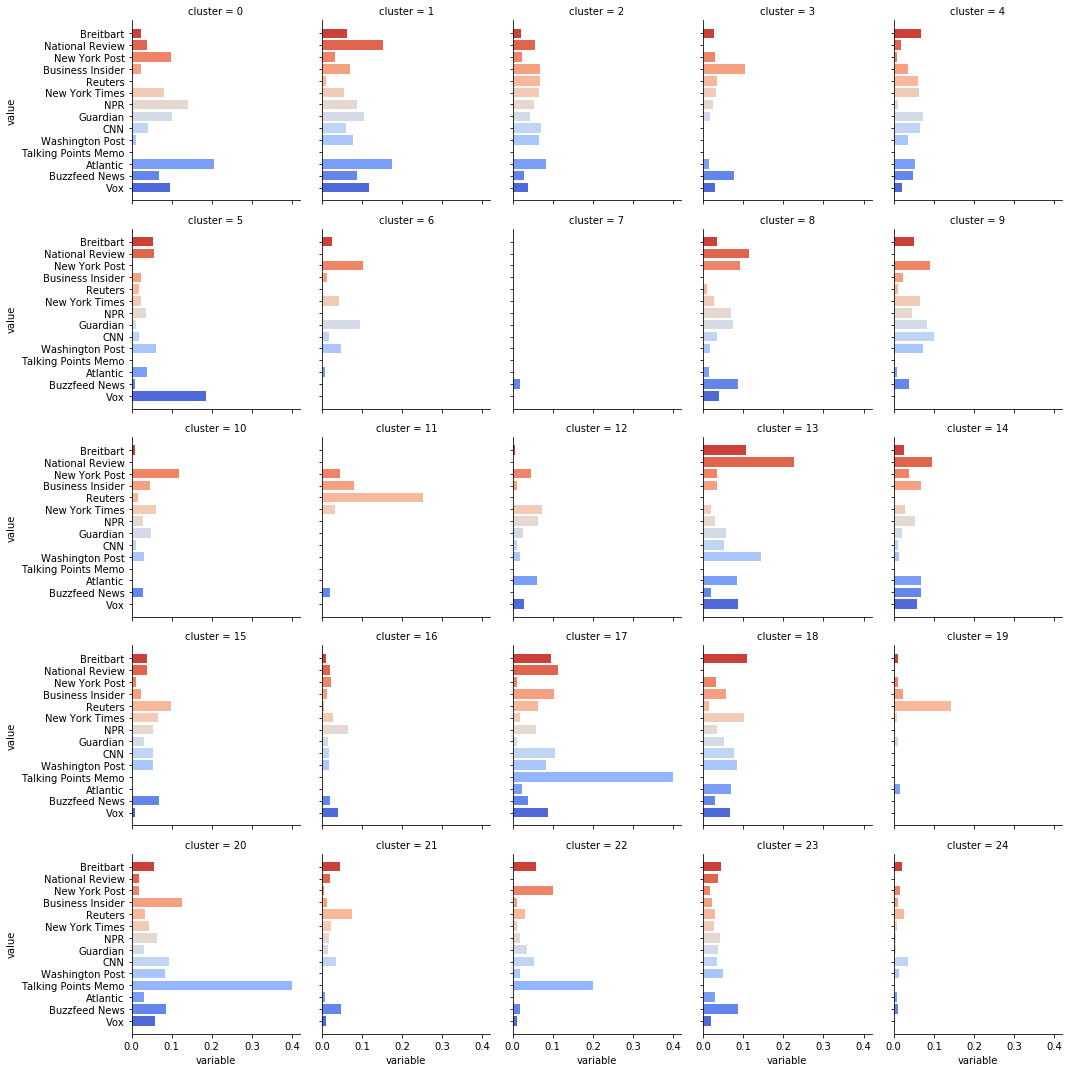

In [90]:
g = sns.FacetGrid(test_av_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Cluster 19 is still dominated by Reuters in the test set, and to a lesser extent so is cluster 11. However, the larger Reuters element has disappeared from cluster 4 suggesting it was not a stable predictive cluster.

Clsuter 5 now appears to favor Vox rather than left wing publications in particular, given the change in clustering of Talking Points Memo. Cluster 13 is similarly slightly predictive of right wing publications.

Clusters 9 and 10 do appear to be slightly predictive of centrist publications.

#### word2vec (maximum) publication clusters

In [91]:
## 25 clusters

kmeans_train_max_g1_25 = KMeans(n_clusters=25, random_state=76).fit(max_train_g1)
ypred_train_max_g1_25 = kmeans_train_max_g1_25.predict(max_train_g1)

train_max_g1_cl25 = pd.crosstab(ypred_train_max_g1_25, train['publication'])
train_max_g1_cl25pct = table_pct(train_max_g1_cl25, pub_counts_train)
train_max_g1_cl25pct.reset_index(inplace=True)
train_max_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_max_g1_cl25pct_long = pd.melt(train_max_g1_cl25pct, id_vars='cluster')

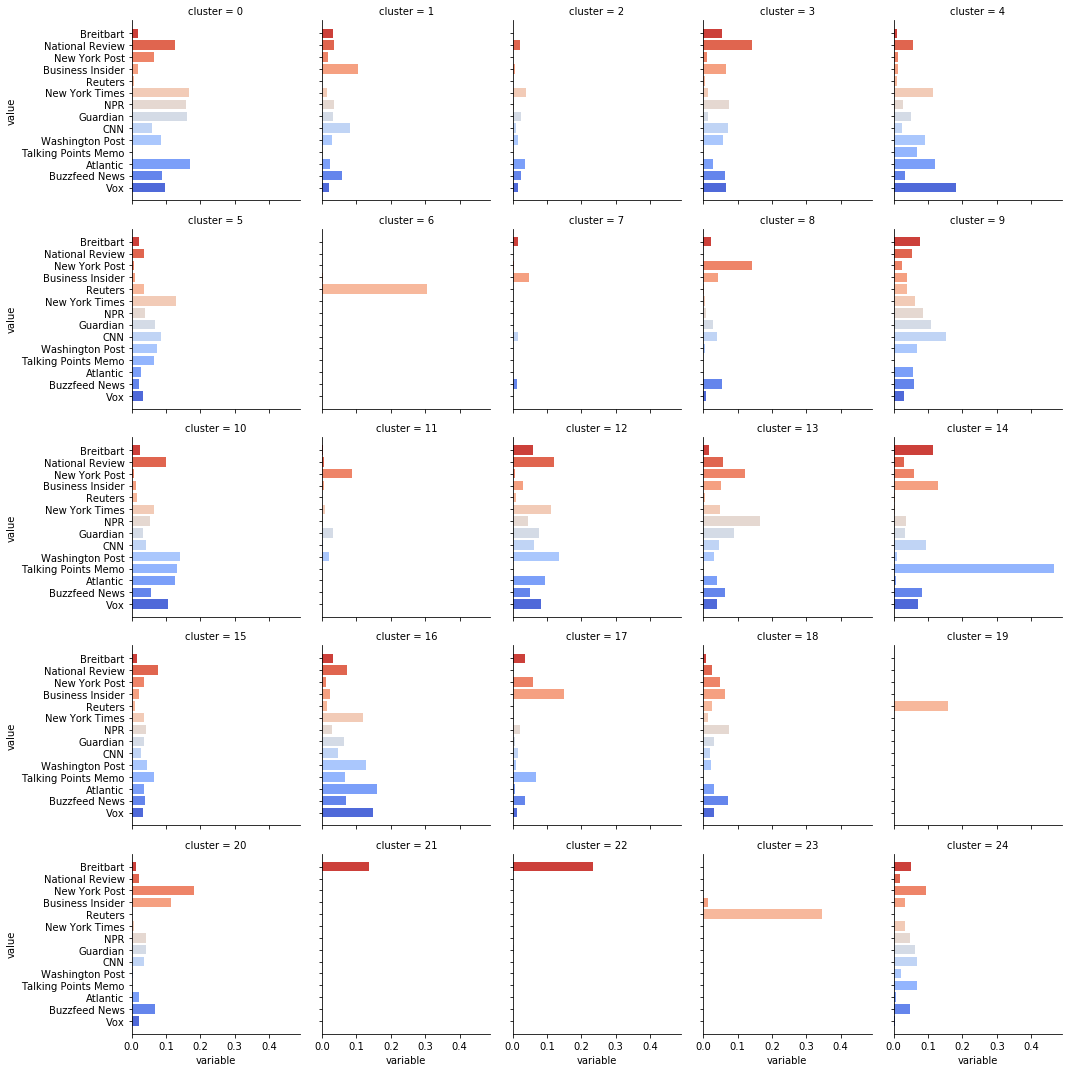

In [93]:
g = sns.FacetGrid(train_max_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

This is exciting. Here there are three Reuters clusters (6, 19 and 23) which together find around 75% of all Reuters articles with almost zero other publications included in these clusters. Around 30% of Breitbart articles are identified in almost solo clusters, 21 and 22. Also, nearly 50% of Talking Points Memo articles are in cluster 14.

Ideological bias also appears to be noticeable towards the left in clusters 4, 10 and 16, and towards the right in 17 and 20. Clusters 5, 9 and 13 may be predictive of a centrist publication.

In [94]:
## 25 clusters - test on test set

ypred_test_max_g1_25 = kmeans_train_max_g1_25.predict(max_test_g1)

test_max_g1_cl25 = pd.crosstab(ypred_test_max_g1_25, test['publication'])
test_max_g1_cl25pct = table_pct(test_max_g1_cl25, pub_counts_test)
test_max_g1_cl25pct.reset_index(inplace=True)
test_max_g1_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_max_g1_cl25pct_long = pd.melt(test_max_g1_cl25pct, id_vars='cluster')

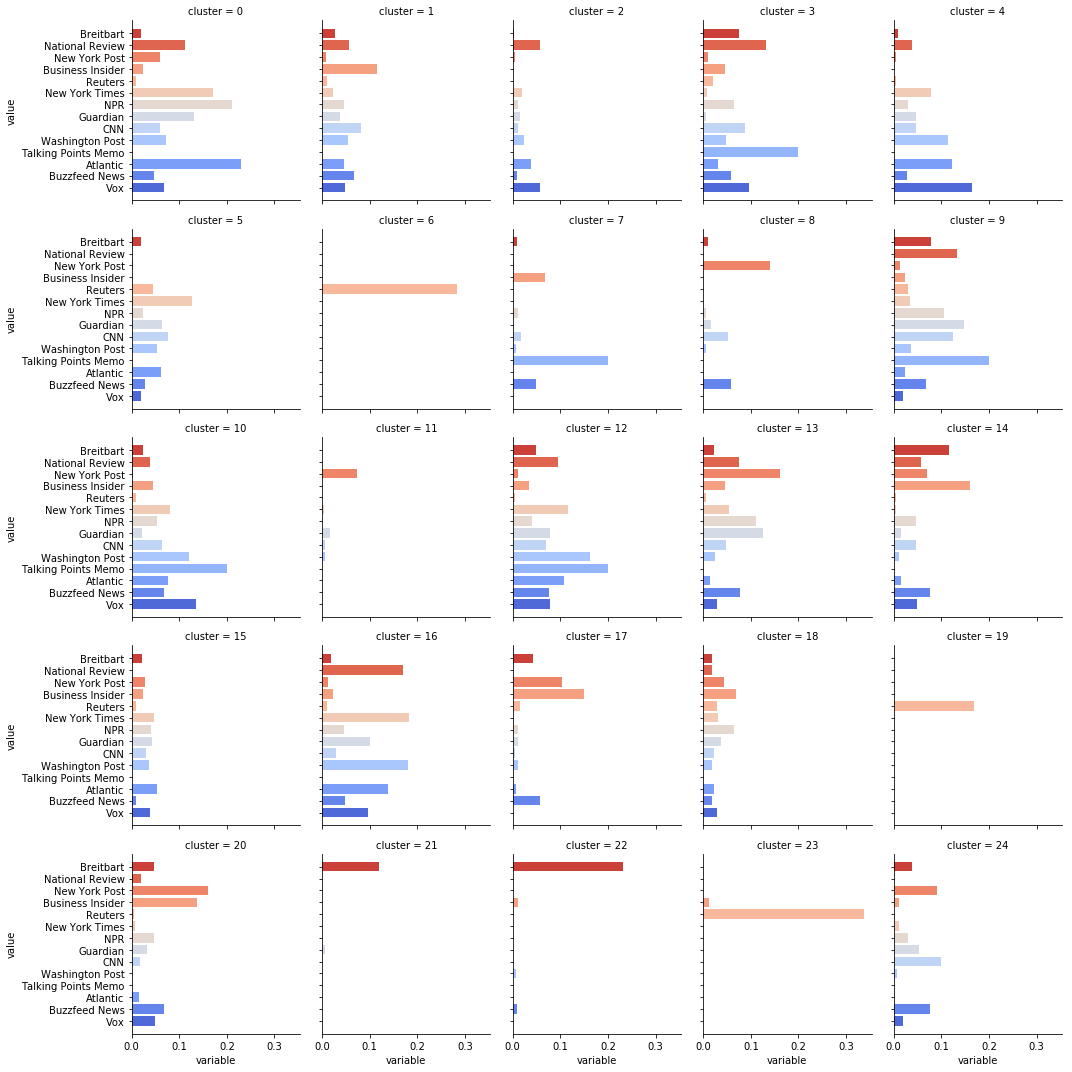

In [95]:
g = sns.FacetGrid(test_max_g1_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The Reuters and the Breitbart clusters have remained, suggesting these are stable clusters. The Talking Points Memo cluster has completely disappeared, suggesting this is not!

Left wing bias is still visible in clusters 4 and 10 but not 16. Clusters 17 and 20 still have some right wing bias. Clusters 5, 9 and 13 are still relatively good at predicting centrist publications.

#### Bag of Words publication clusters

In [97]:
## 25 clusters

kmeans_train_bow_25 = KMeans(n_clusters=25, random_state=76).fit(x_train_bow)
ypred_train_bow_25 = kmeans_train_bow_25.predict(x_train_bow)

train_bow_cl25 = pd.crosstab(ypred_train_bow_25, train['publication'])
train_bow_cl25pct = table_pct(train_bow_cl25, pub_counts_train)
train_bow_cl25pct.reset_index(inplace=True)
train_bow_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_bow_cl25pct_long = pd.melt(train_bow_cl25pct, id_vars='cluster')

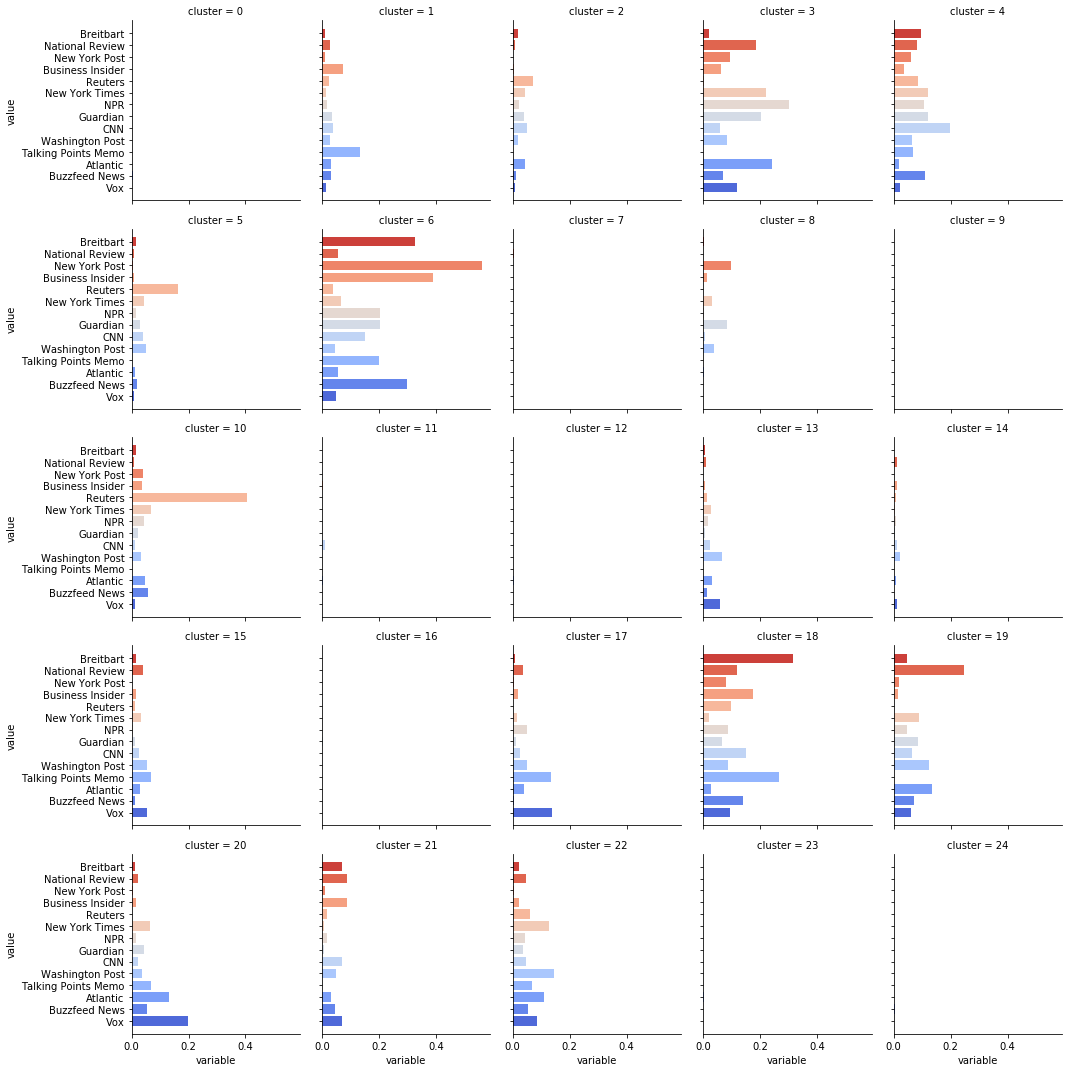

In [98]:
g = sns.FacetGrid(train_bow_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Several clusters here have a very tiny number of articles within them. Reuters again stands out in a cluster, number 10, but not to the extent seen in the word2vec max clustering. None of the other publications particularly stand out in a cluster.

Clusters 17 and 20 look to indicate left wing bias and cluster 5 groups centrist publications, but there is limited other information available from these clusters.

In [99]:
## 25 clusters

ypred_test_bow_25 = kmeans_train_bow_25.predict(x_test_bow)

test_bow_cl25 = pd.crosstab(ypred_test_bow_25, test['publication'])
test_bow_cl25pct = table_pct(test_bow_cl25, pub_counts_test)
test_bow_cl25pct.reset_index(inplace=True)
test_bow_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_bow_cl25pct_long = pd.melt(test_bow_cl25pct, id_vars='cluster')

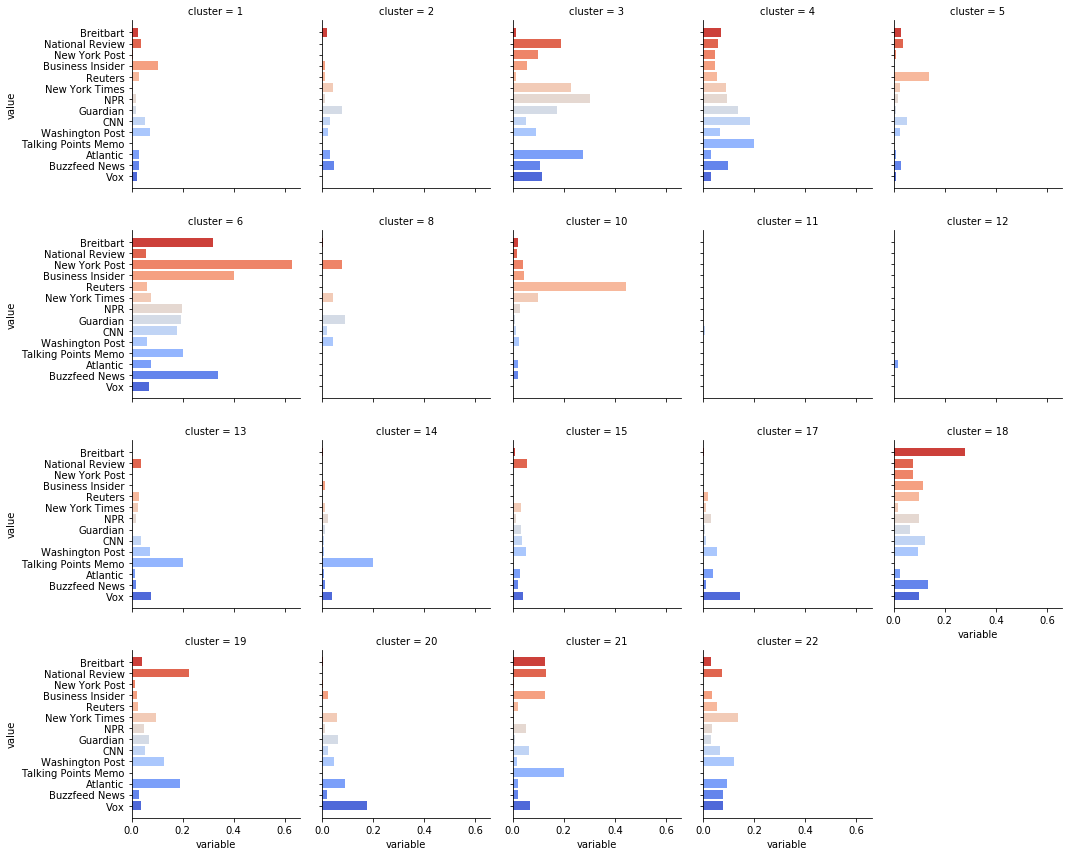

In [100]:
g = sns.FacetGrid(test_bow_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

Not all the clusters were used in the test set. The Reuters cluster 10 is stable, and there is still left wing predictiveness in clusters 17 and 20 (though mostly relating to Vox specifically), but there are not really any further discriminating clusters.

#### tf-idf publication clusters

In [107]:
## 25 clusters

kmeans_train_tfidf_25 = KMeans(n_clusters=25, random_state=76).fit(x_train_tfidf)
ypred_train_tfidf_25 = kmeans_train_tfidf_25.predict(x_train_tfidf)

train_tfidf_cl25 = pd.crosstab(ypred_train_tfidf_25, train['publication'])
train_tfidf_cl25pct = table_pct(train_tfidf_cl25, pub_counts_train)
train_tfidf_cl25pct.reset_index(inplace=True)
train_tfidf_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
train_tfidf_cl25pct_long = pd.melt(train_tfidf_cl25pct, id_vars='cluster')

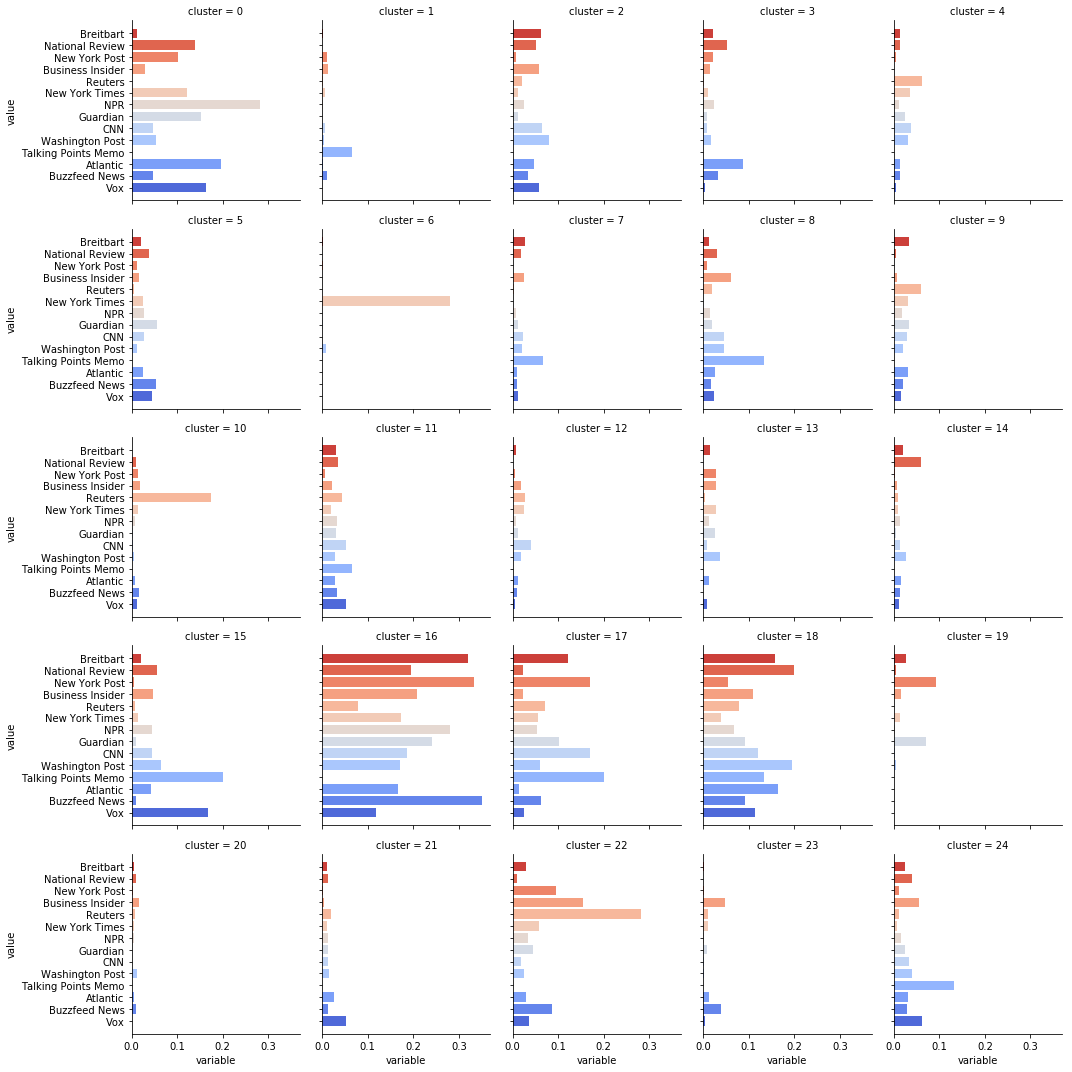

In [108]:
g = sns.FacetGrid(train_tfidf_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

As usual there is a Reuters cluster (number 10) but surprisingly there is a larger single cluster focused on the New York Times (cluster 6). Cluster 15 may indicate a slight left wing bias and clsuter 22 a slight right wing bias, but the majority of the clusters do not differentiate between different publications well.

In [109]:
## 25 clusters

ypred_test_tfidf_25 = kmeans_train_tfidf_25.predict(x_test_tfidf)

test_tfidf_cl25 = pd.crosstab(ypred_test_tfidf_25, test['publication'])
test_tfidf_cl25pct = table_pct(test_tfidf_cl25, pub_counts_test)
test_tfidf_cl25pct.reset_index(inplace=True)
test_tfidf_cl25pct.rename(columns={'index': 'cluster'}, inplace=True)
test_tfidf_cl25pct_long = pd.melt(test_tfidf_cl25pct, id_vars='cluster')

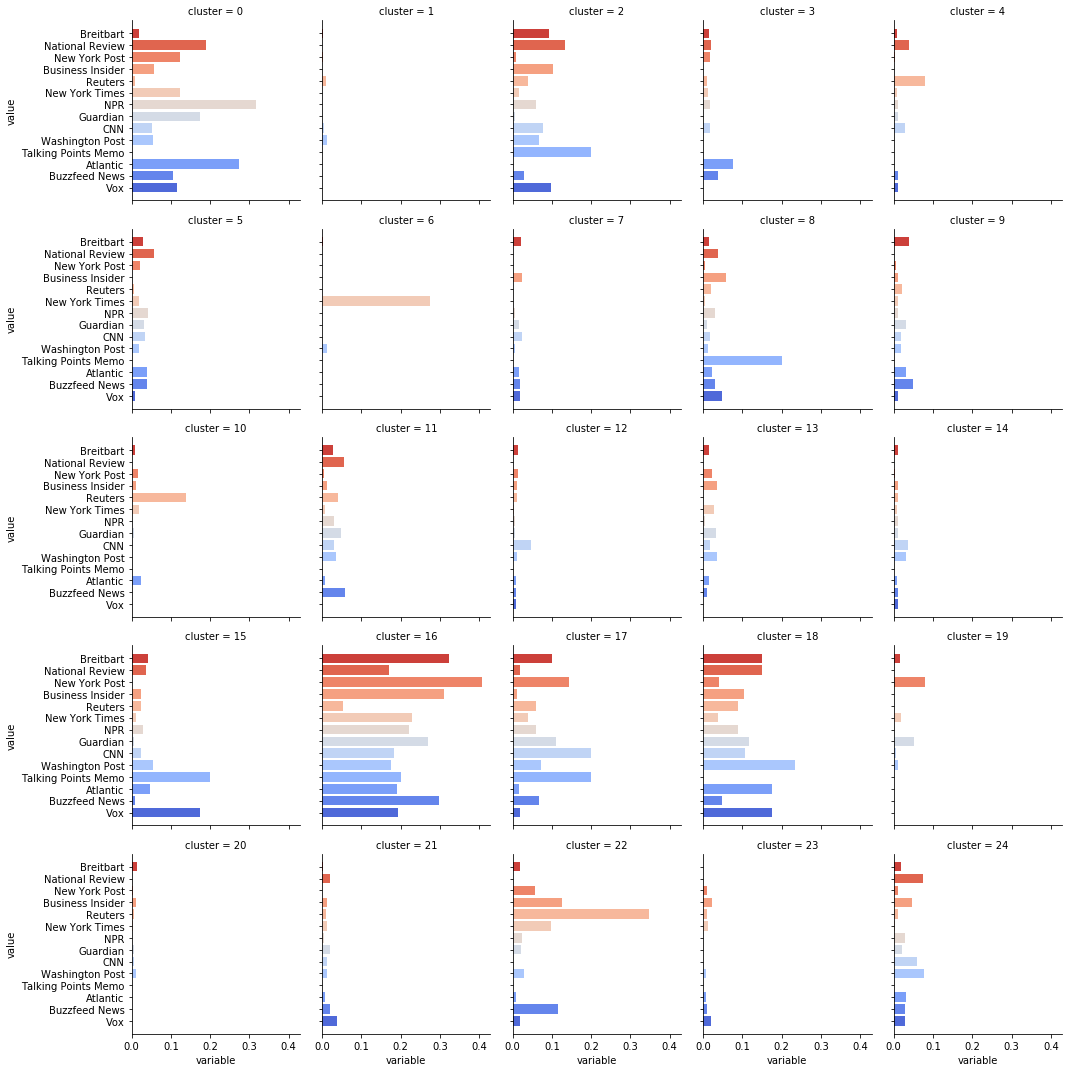

In [110]:
g = sns.FacetGrid(test_tfidf_cl25pct_long, col='cluster', col_wrap=5, hue='variable', palette='coolwarm')
g = g.map(plt.barh, 'variable', 'value')
plt.show()

The Reuters and New York Times clusters have remained in the test set suggesting these are stable clusters. There is also a consistency in the bias shown by clusters 15 and 22.

### Overall comments on publication clusters

When using K-Means to group articles into clusters based on which publication they are from, by far the best method was to process the articles using Google's word2vec algorithm, and then extract the maximum vector for each article.

All methods tested managed to identify a mostly Reuters cluster. However, the maximum word2vec method differentiated nearly 80% of Reuters articles as well as around 40% of Breitbart articles. The method also found some stable clusters which predicted left wing and right wing bias, as well as others which reliably indicated a centrist publication.

Given a single article, currently it would not be easy to predict the publication the article came from, unless it happened to fall into one of around five clusters (the Reuters and Breitbart ones). However, it may be possible to improve on the current clustering by changing the clustering algorithm (e.g. MiniBatchKMeans), the clustering parameters (e.g. more / fewer clusters) or the word vectors themselves (e.g. change the size, or combine with the minimum or average vectors).

### Clustering by author

It would be interesting to know whether it is possible to cluster articles for a single publication by author. If so, this would mean that the method and algorithm could predict which author had written any given article from a publication based on information about the style and content of the article.

To experiment with this, the top 10 authors from Vox were used, consisting of 117 articles in the training set.

#### Selecting the data

In [114]:
## Find the most prolific Vox authors

vox = march17news.loc[march17news['publication'] == 'Vox']
top_vox_authors = pd.DataFrame(vox.author.value_counts().head(10))
top_vox_authors

,author
Matthew Yglesias,27
German Lopez,20
Andrew Prokop,20
Zack Beauchamp,18
Sarah Kliff,17
Julia Belluz,15
Ezra Klein,14
Dylan Matthews,13
Timothy B. Lee,12
Dara Lind,11


In [115]:
## Select the article id and the corresponding author from the training set

train_authors = train.loc[train['author'].isin(top_vox_authors.index), ['article_id', 'author']]
train_authors.head()

,article_id,author
87,8673,Julia Belluz
110,8909,Sarah Kliff
166,8778,Matthew Yglesias
306,8618,Matthew Yglesias
395,8629,Matthew Yglesias


In [129]:
## Count number of articles by each author for percentage calculations

auth_counts_train = pd.DataFrame(train_authors['author'].value_counts())

In [131]:
## Formula to convert results into percentages within each cluster

def table_auth_pct(df, totals):
    df_new = pd.DataFrame(columns=train_authors['author'])
    for row in df.index:
        for pub in totals.index:
            df_new.loc[row, pub] = df.loc[row, pub] / totals.loc[pub, 'author']
    return df_new

In [126]:
## Select relevant rows from different methods

## doc2vec
x_train_d2v_vox = x_train_d2v.loc[x_train_d2v.index.isin(train_authors.index), ]

## Google word2vec average
av_train_g1 = pd.DataFrame(av_train_g1)
av_train_g1_vox = av_train_g1.loc[av_train_g1.index.isin(train_authors.index), ]

## Google word2vec max
max_train_g1 = pd.DataFrame(max_train_g1)
max_train_g1_vox = max_train_g1.loc[max_train_g1.index.isin(train_authors.index), ]

## BoW
x_train_bow_vox = x_train_bow.loc[x_train_bow.index.isin(train_authors.index), ]

## tf-idf
train_vox = train.loc[train.index.isin(train_authors.index), ]
train_str_vox = train_vox.loc[:, 'content'].values
vox_train_tfidf_v = vectorizer.fit(train_str_vox)
vox_train_tfidf = vox_train_tfidf_v.transform(train_str_vox)
print('Number of features: {}'.format(vox_train_tfidf.get_shape()[1]))

Number of features: 1212


To visualize the clusters of articles the features need to be transformed into two dimensions. This has been done using PCA, which is a technique that reduces the information contained in a certain number of features into a smaller number - in this case 2.

In [147]:
## PCA each method to allow plotting in two dimensions

pca_vox_2d = PCA(n_components=2, random_state=76)

## doc2vec
x_train_d2v_vox_pca = pca_vox_2d.fit_transform(x_train_d2v_vox)
x_train_d2v_vox_pca = pd.DataFrame(x_train_d2v_vox_pca)

## Google word2vec average
av_train_g1_vox_pca = pca_vox_2d.fit_transform(av_train_g1_vox)
av_train_g1_vox_pca = pd.DataFrame(av_train_g1_vox_pca)

## Google word2vec max
max_train_g1_vox_pca = pca_vox_2d.fit_transform(max_train_g1_vox)
max_train_g1_vox_pca = pd.DataFrame(max_train_g1_vox_pca)

## BoW
x_train_bow_vox_pca = pca_vox_2d.fit_transform(x_train_bow_vox)
x_train_bow_vox_pca = pd.DataFrame(x_train_bow_vox_pca)

## tfidf - doesn't work for sparse matrices
#vox_train_tfidf_pca = pca_vox_2d.fit_transform(vox_train_tfidf)

#### doc2vec

The actual distribution of authors in two dimensional space using doc2vec and PCA is shown below.

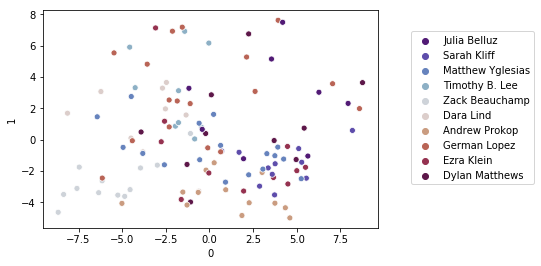

In [182]:
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=train_authors['author'].values, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))
plt.show()

Some authors are clearly in one area of the graph, although there are no distinct clusters here. However, this is an approximation of multiple dimensions into two dimensions so the fact that no clusters are clearly discernable does not mean the algorithm won't find any.

In [132]:
## 10 clusters

kmeans_train_d2v_vox_10 = KMeans(n_clusters=10, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_10 = kmeans_train_d2v_vox_10.predict(x_train_d2v_vox)

train_d2v_vox_cl10 = pd.crosstab(ypred_train_d2v_vox_10, train_authors['author'])
train_d2v_vox_cl10pct = table_auth_pct(train_d2v_vox_cl10, auth_counts_train)
train_d2v_vox_cl10pct.reset_index(inplace=True)
train_d2v_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl10pct_long = pd.melt(train_d2v_vox_cl10pct, id_vars='cluster')

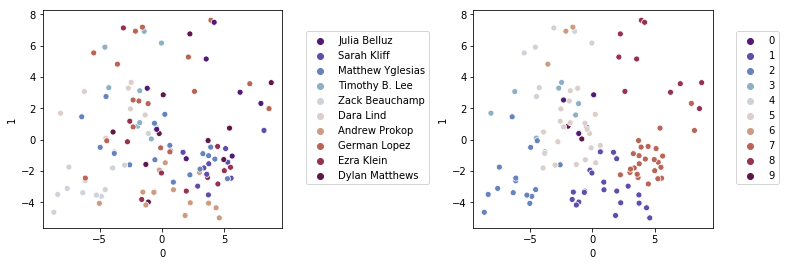

In [210]:
fig = plt.figure(figsize=(12, 4))
plt.subplots_adjust(wspace=0.8)

ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=train_authors['author'].values, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))

ax2 = fig.add_subplot(1, 2, 2)
sns.scatterplot(x=x_train_d2v_vox_pca[0], 
                y=x_train_d2v_vox_pca[1], 
                hue=ypred_train_d2v_vox_10, 
                palette=sns.color_palette('twilight_shifted', 10))
plt.legend(loc=(1.1, 0.2))
plt.show()

The clusters found by the KMeans algorithm correspond to the actual groupings of authors in some places but not in others. The bottom left and middle shows some consistent clustering. This is more clearly seen in the bar charts below.

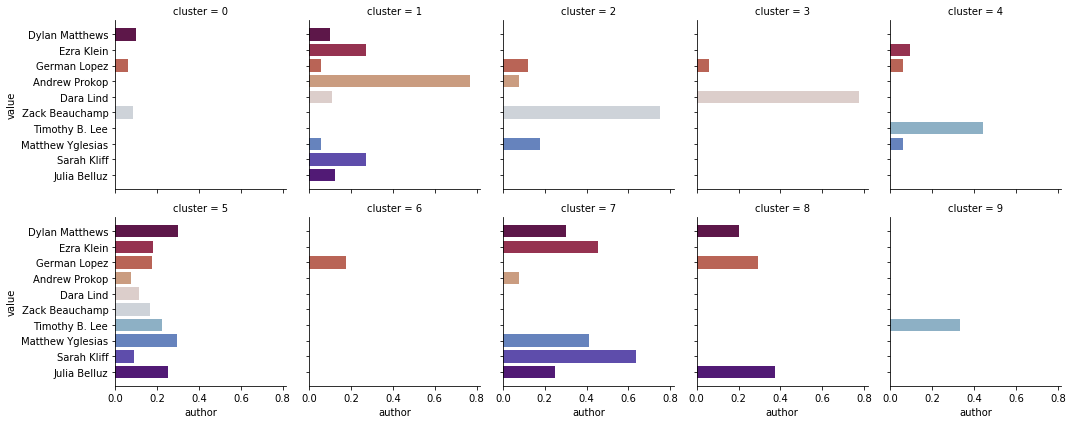

In [196]:
g = sns.FacetGrid(train_d2v_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Reasonably good clusters have been found for four authors - Andrew Prokop (1), Zack Beauchamp (2), Dara Lind (3) and Timothy B Lee (4 and 9).

It is possible that ten is not the optimal number of clusters. The graphs below show the results using a different number of clusters - 11, 12, and 9.

In [213]:
## 11 clusters

kmeans_train_d2v_vox_11 = KMeans(n_clusters=11, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_11 = kmeans_train_d2v_vox_11.predict(x_train_d2v_vox)

train_d2v_vox_cl11 = pd.crosstab(ypred_train_d2v_vox_11, train_authors['author'])
train_d2v_vox_cl11pct = table_auth_pct(train_d2v_vox_cl11, auth_counts_train)
train_d2v_vox_cl11pct.reset_index(inplace=True)
train_d2v_vox_cl11pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl11pct_long = pd.melt(train_d2v_vox_cl11pct, id_vars='cluster')

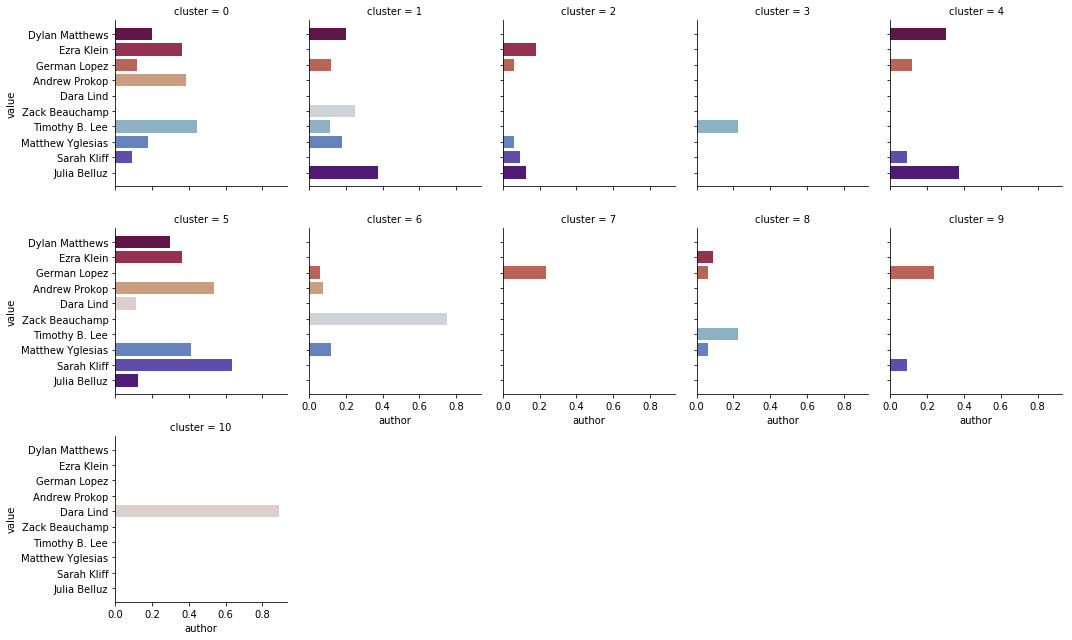

In [214]:
g = sns.FacetGrid(train_d2v_vox_cl11pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [211]:
## 12 clusters

kmeans_train_d2v_vox_12 = KMeans(n_clusters=12, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_12 = kmeans_train_d2v_vox_12.predict(x_train_d2v_vox)

train_d2v_vox_cl12 = pd.crosstab(ypred_train_d2v_vox_12, train_authors['author'])
train_d2v_vox_cl12pct = table_auth_pct(train_d2v_vox_cl12, auth_counts_train)
train_d2v_vox_cl12pct.reset_index(inplace=True)
train_d2v_vox_cl12pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl12pct_long = pd.melt(train_d2v_vox_cl12pct, id_vars='cluster')

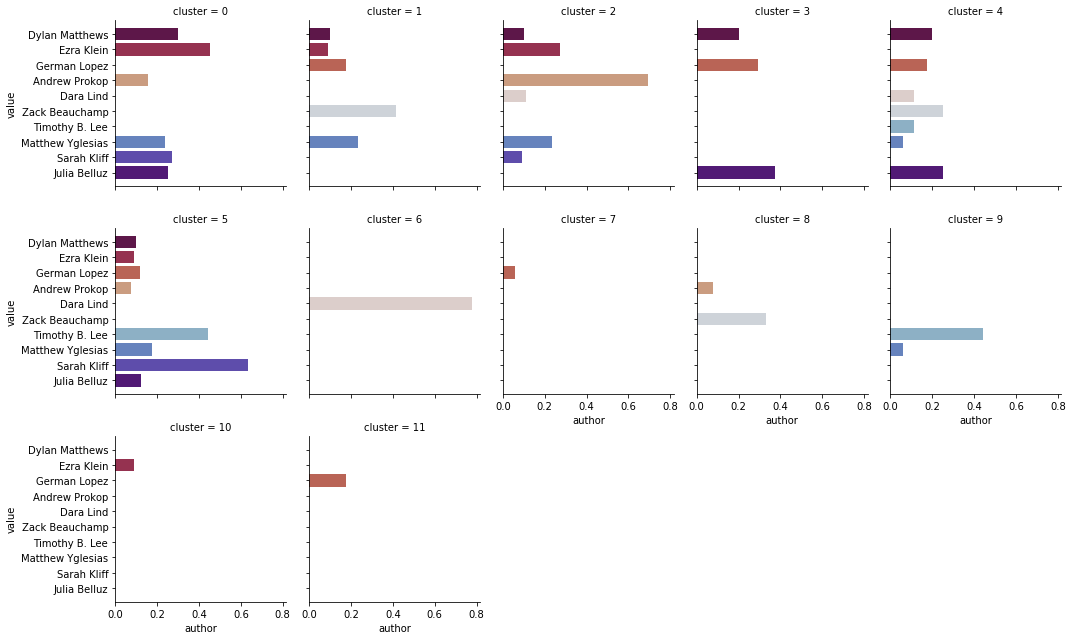

In [212]:
g = sns.FacetGrid(train_d2v_vox_cl12pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

In [215]:
## 9 clusters

kmeans_train_d2v_vox_9 = KMeans(n_clusters=9, random_state=76).fit(x_train_d2v_vox)
ypred_train_d2v_vox_9 = kmeans_train_d2v_vox_9.predict(x_train_d2v_vox)

train_d2v_vox_cl9 = pd.crosstab(ypred_train_d2v_vox_9, train_authors['author'])
train_d2v_vox_cl9pct = table_auth_pct(train_d2v_vox_cl9, auth_counts_train)
train_d2v_vox_cl9pct.reset_index(inplace=True)
train_d2v_vox_cl9pct.rename(columns={'index': 'cluster'}, inplace=True)
train_d2v_vox_cl9pct_long = pd.melt(train_d2v_vox_cl9pct, id_vars='cluster')

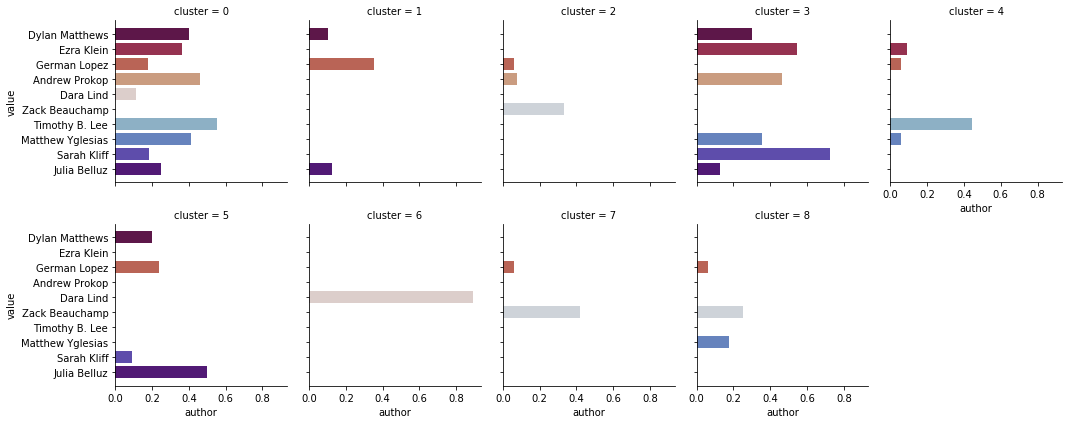

In [216]:
g = sns.FacetGrid(train_d2v_vox_cl9pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

None of these alternative number of clusters clearly differentiate between as many authors as 10 clusters. However, some interesting similarities are seen. Dara Lind is clearly clustered in all variations suggesting that this author writes particularly differently to other authors. The next most clearly defined author is probably Zack Beauchamp.

Dylan Matthews and Ezra Klein are often clustered together (sometimes with other authors), perhaps indicating that these two authors are quite similar.

This clustering technique was tested with the other methods of classifying articles to see if this improved the clusters found.

#### word2vec average

In [218]:
## 10 clusters

kmeans_train_av_g1_vox_10 = KMeans(n_clusters=10, random_state=76).fit(av_train_g1_vox)
ypred_train_av_g1_vox_10 = kmeans_train_av_g1_vox_10.predict(av_train_g1_vox)

train_av_g1_vox_cl10 = pd.crosstab(ypred_train_av_g1_vox_10, train_authors['author'])
train_av_g1_vox_cl10pct = table_auth_pct(train_av_g1_vox_cl10, auth_counts_train)
train_av_g1_vox_cl10pct.reset_index(inplace=True)
train_av_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_av_g1_vox_cl10pct_long = pd.melt(train_av_g1_vox_cl10pct, id_vars='cluster')

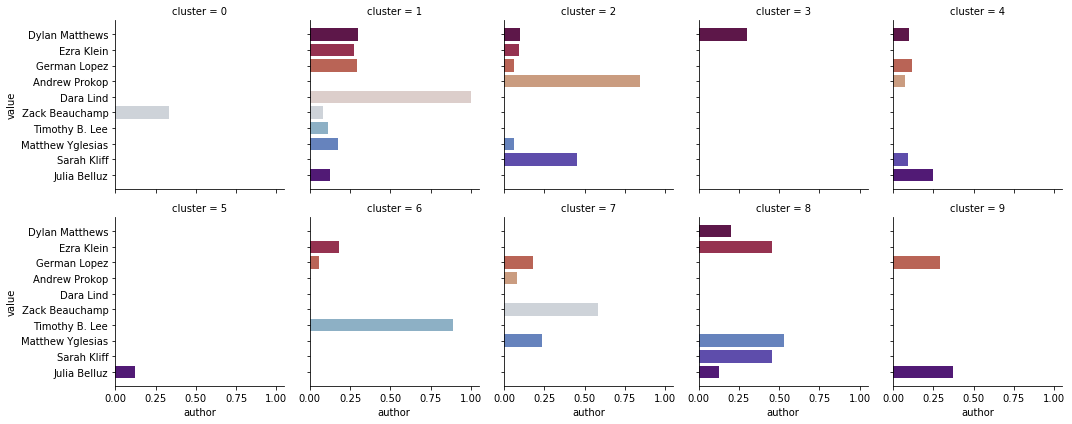

In [219]:
g = sns.FacetGrid(train_av_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

The same authors stand out using this method as did with doc2vec.

#### word2vec maximum

In [220]:
## 10 clusters

kmeans_train_max_g1_vox_10 = KMeans(n_clusters=10, random_state=76).fit(max_train_g1_vox)
ypred_train_max_g1_vox_10 = kmeans_train_max_g1_vox_10.predict(max_train_g1_vox)

train_max_g1_vox_cl10 = pd.crosstab(ypred_train_max_g1_vox_10, train_authors['author'])
train_max_g1_vox_cl10pct = table_auth_pct(train_max_g1_vox_cl10, auth_counts_train)
train_max_g1_vox_cl10pct.reset_index(inplace=True)
train_max_g1_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_max_g1_vox_cl10pct_long = pd.melt(train_max_g1_vox_cl10pct, id_vars='cluster')

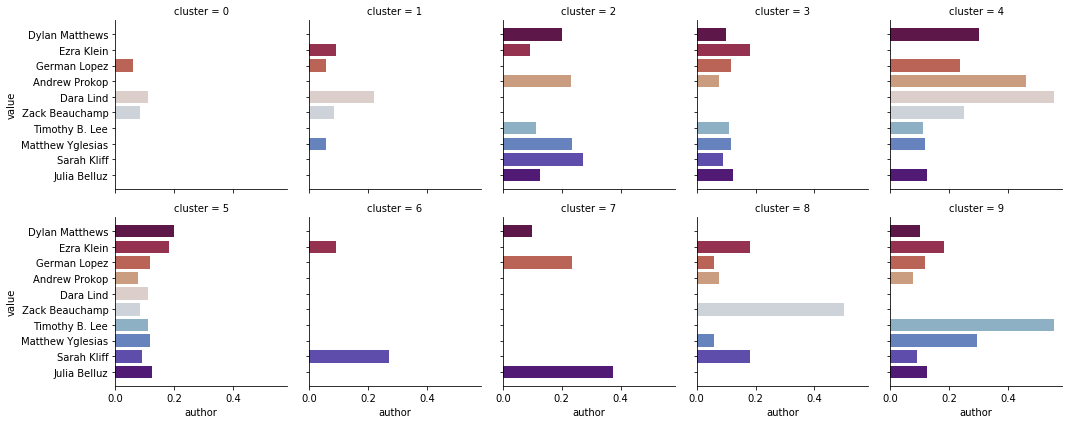

In [221]:
g = sns.FacetGrid(train_max_g1_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()

Interestingly, despite being the best predictor for publications, the maximum word2vec method does not discern well between different authors. Most clusters have a mix of all authors.

This could be because word2vec maximums capture a general theme, or feeling, from an article. This might be a good predictor of a publication because publications have particular topics, or themes, that they return to. For example, more left leaning publications may write more about environmental issues, whereas right leaning ones may write more about business. However, authors for a specific publication may write about a range of different issues, meaning that grouping by themes is not a good way to find groups of authors.

#### Bag of Words

In [222]:
## 10 clusters

kmeans_train_bow_vox_10 = KMeans(n_clusters=10, random_state=76).fit(x_train_bow_vox)
ypred_train_bow_vox_10 = kmeans_train_bow_vox_10.predict(x_train_bow_vox)

train_bow_vox_cl10 = pd.crosstab(ypred_train_bow_vox_10, train_authors['author'])
train_bow_vox_cl10pct = table_auth_pct(train_bow_vox_cl10, auth_counts_train)
train_bow_vox_cl10pct.reset_index(inplace=True)
train_bow_vox_cl10pct.rename(columns={'index': 'cluster'}, inplace=True)
train_bow_vox_cl10pct_long = pd.melt(train_bow_vox_cl10pct, id_vars='cluster')

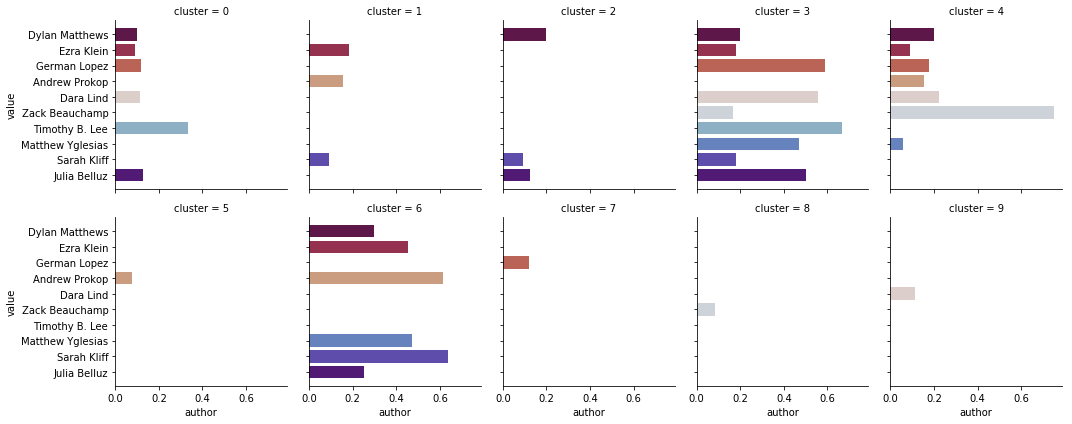

In [223]:
g = sns.FacetGrid(train_bow_vox_cl10pct_long, col='cluster', col_wrap=5, hue='author', palette='twilight_shifted')
g = g.map(plt.barh, 'author', 'value')
plt.show()